# Time Series Forecasting

----

## General Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.1.0


----

## Initializing the Dataset

In [2]:
import urllib.request as req
import csv

time = []
sunspots = []

url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv'
filename = 'sunspots.csv'
req.urlretrieve(url, filename)

with open(filename) as file:
    reader = csv.reader(file, delimiter = ',')
    next(reader)
    
    for row in reader:
        time.append(int(row[0]))
        sunspots.append(float(row[2]))
        
time = np.array(time)
sunspots = np.array(sunspots)

----

## Plotting the Dataset

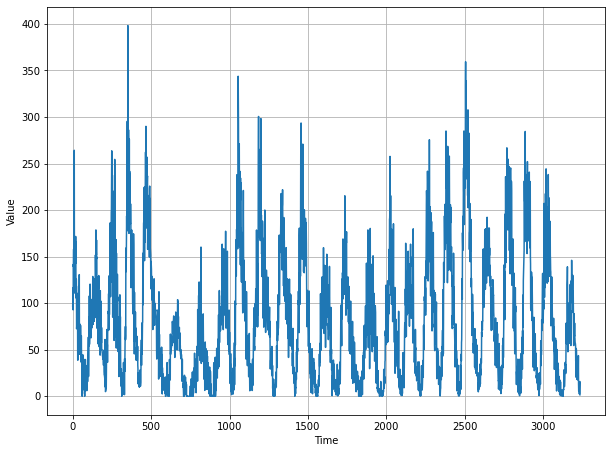

In [3]:
figsize = plt.rcParams['figure.figsize']
figsize[0] = 10
figsize[1] = 7.5

def plotter(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
plotter(time, sunspots)
plt.show()

----

## Series Windowing Functions

**Windowing Example:**
window([1, 2, 3, 4, 5], shift = 1, size = 2) = [
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5],
    [5]
]

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):   
    # Prevents a dimension error caused when transforming the series to the numpy type.
    series = tf.expand_dims(series, axis = -1)
    # Creates a Dataset object from the series.
    data = tf.data.Dataset.from_tensor_slices(series)
    # Creates windows out of the dataset. drop_remainder will ensure all windows are of the same size.
    data = data.window(window_size + 1, shift = 1, drop_remainder = True)
    # Flattens out the dataset to account for the extra dimension in the series.
    data = data.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffles the dataset.
    data = data.shuffle(shuffle_buffer)
    # Separates the data into input and expected output.
    data = data.map(lambda window: (window[:-1], window[-1:]))
    # Returns the data separated into batches.
    return data.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis = -1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size, shift = 1, drop_remainder = True)
    data = data.flat_map(lambda window: window.batch(window_size))
    data = data.batch(32).prefetch(1)
    return model.predict(data)

----

## Creating Training & Testing Values

In [5]:
split_time = 3000
X_train = time[:split_time]
X_test = time[split_time:]
y_train = sunspots[:split_time]
y_test = sunspots[split_time:]


window_size = 64
batch_size = 256
shuffle_buffer = 1000
seed = 4

tf.random.set_seed(seed)
y_train = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer)

----

## Creating the Original Model

In [6]:
def create_model():
    tf.keras.backend.clear_session()

    return tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(32, 5, 1, padding = 'causal', activation = 'relu', input_shape = [None, 1]),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda output: output * 400)
    ])
    
    
model = create_model()
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

----

## Fitting the Model to Find Learning Rate

Epoch 1/100
12/12 [==============================] - 4s 362ms/step - loss: 77.5079 - mae: 77.6512
Epoch 2/100
12/12 [==============================] - 0s 40ms/step - loss: 76.3661 - mae: 76.9848
Epoch 3/100
12/12 [==============================] - 0s 41ms/step - loss: 75.5034 - mae: 75.9976
Epoch 4/100
12/12 [==============================] - 0s 41ms/step - loss: 74.5804 - mae: 74.8120
Epoch 5/100
12/12 [==============================] - 1s 42ms/step - loss: 73.1040 - mae: 73.3854
Epoch 6/100
12/12 [==============================] - 0s 41ms/step - loss: 70.9063 - mae: 71.4218
Epoch 7/100
12/12 [==============================] - 1s 42ms/step - loss: 66.6530 - mae: 66.9168
Epoch 8/100
12/12 [==============================] - 0s 42ms/step - loss: 62.1084 - mae: 62.2750
Epoch 9/100
12/12 [==============================] - 1s 42ms/step - loss: 61.0139 - mae: 61.3785
Epoch 10/100
12/12 [==============================] - 0s 42ms/step - loss: 60.2384 - mae: 60.7818
Epoch 11/100
12/12 [========

(1e-08, 0.0001, 0.0, 60.0)

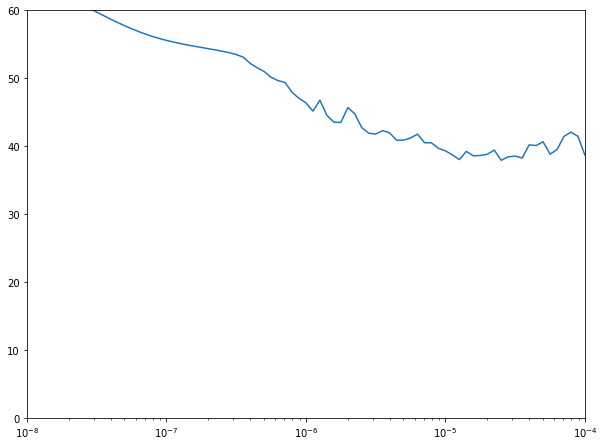

In [7]:
figsize = plt.rcParams['figure.figsize']
figsize[0] = 10
figsize[1] = 7.5

results = model.fit(y_train, epochs = 100, callbacks = [lr_scheduler])
plt.semilogx(results.history['lr'], results.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

----

## Fitting the Model /w Optimal Learning Rate

In [8]:
model = create_model()

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ['mae'])
results = model.fit(y_train, epochs = 500)

Epoch 1/500
12/12 [==============================] - 3s 278ms/step - loss: 61.5104 - mae: 62.4712
Epoch 2/500
12/12 [==============================] - 1s 42ms/step - loss: 46.8682 - mae: 47.4329
Epoch 3/500
12/12 [==============================] - 1s 43ms/step - loss: 44.8876 - mae: 45.4755
Epoch 4/500
12/12 [==============================] - 1s 44ms/step - loss: 43.3732 - mae: 43.7851
Epoch 5/500
12/12 [==============================] - 1s 45ms/step - loss: 43.2005 - mae: 43.6071
Epoch 6/500
12/12 [==============================] - 1s 43ms/step - loss: 43.2167 - mae: 43.7063
Epoch 7/500
12/12 [==============================] - 1s 44ms/step - loss: 44.7053 - mae: 45.1324
Epoch 8/500
12/12 [==============================] - 1s 44ms/step - loss: 44.3709 - mae: 44.9574
Epoch 9/500
12/12 [==============================] - 1s 45ms/step - loss: 44.6678 - mae: 45.1803
Epoch 10/500
12/12 [==============================] - 1s 44ms/step - loss: 43.5758 - mae: 44.3470
Epoch 11/500
12/12 [========

12/12 [==============================] - 1s 46ms/step - loss: 32.8820 - mae: 33.3744
Epoch 168/500
12/12 [==============================] - 1s 44ms/step - loss: 32.4397 - mae: 32.8031
Epoch 169/500
12/12 [==============================] - 1s 45ms/step - loss: 32.1504 - mae: 32.6889
Epoch 170/500
12/12 [==============================] - 1s 43ms/step - loss: 31.5481 - mae: 32.1233
Epoch 171/500
12/12 [==============================] - ETA: 0s - loss: 31.0464 - mae: 31.542 - 1s 42ms/step - loss: 31.2070 - mae: 31.5804
Epoch 172/500
12/12 [==============================] - 1s 42ms/step - loss: 31.6250 - mae: 31.9897
Epoch 173/500
12/12 [==============================] - 1s 43ms/step - loss: 32.2223 - mae: 32.6815
Epoch 174/500
12/12 [==============================] - 1s 42ms/step - loss: 31.9910 - mae: 32.5201
Epoch 175/500
12/12 [==============================] - 1s 44ms/step - loss: 31.6061 - mae: 32.2226
Epoch 176/500
12/12 [==============================] - 1s 44ms/step - loss: 31.4117

12/12 [==============================] - 1s 50ms/step - loss: 27.3738 - mae: 27.8473
Epoch 331/500
12/12 [==============================] - 1s 47ms/step - loss: 27.4539 - mae: 27.9695
Epoch 332/500
12/12 [==============================] - 1s 47ms/step - loss: 27.5958 - mae: 28.0905
Epoch 333/500
12/12 [==============================] - 1s 46ms/step - loss: 27.5076 - mae: 27.9246
Epoch 334/500
12/12 [==============================] - 1s 46ms/step - loss: 27.4432 - mae: 27.9745
Epoch 335/500
12/12 [==============================] - 1s 48ms/step - loss: 27.9851 - mae: 28.4837
Epoch 336/500
12/12 [==============================] - 1s 45ms/step - loss: 28.2455 - mae: 28.6066
Epoch 337/500
12/12 [==============================] - 1s 48ms/step - loss: 28.0826 - mae: 28.7333
Epoch 338/500
12/12 [==============================] - 1s 47ms/step - loss: 27.8243 - mae: 28.2153
Epoch 339/500
12/12 [==============================] - 1s 44ms/step - loss: 27.7379 - mae: 28.0995
Epoch 340/500
12/12 [===

12/12 [==============================] - 1s 44ms/step - loss: 25.4176 - mae: 25.8037
Epoch 495/500
12/12 [==============================] - 1s 45ms/step - loss: 25.8520 - mae: 26.3040
Epoch 496/500
12/12 [==============================] - 1s 44ms/step - loss: 25.3454 - mae: 25.8567
Epoch 497/500
12/12 [==============================] - 1s 45ms/step - loss: 25.6722 - mae: 26.2473
Epoch 498/500
12/12 [==============================] - 1s 44ms/step - loss: 26.1571 - mae: 26.5112
Epoch 499/500
12/12 [==============================] - 1s 43ms/step - loss: 25.2267 - mae: 25.8694
Epoch 500/500
12/12 [==============================] - 1s 44ms/step - loss: 25.6203 - mae: 26.1390


----

## Visualizing Prediction v.s. Actuality

24.12208


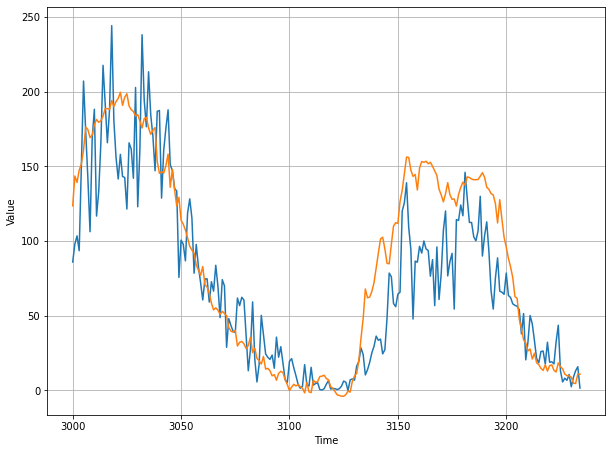

In [9]:
forecast = model_forecast(model, sunspots, window_size, batch_size)
forecast = forecast[(split_time - window_size) : -1, -1, 0]

print(tf.keras.metrics.mean_absolute_error(y_test, forecast).numpy())

plotter(X_test, y_test)
plotter(X_test, forecast)
plt.show()

----

## Visualizing Loss Over Time

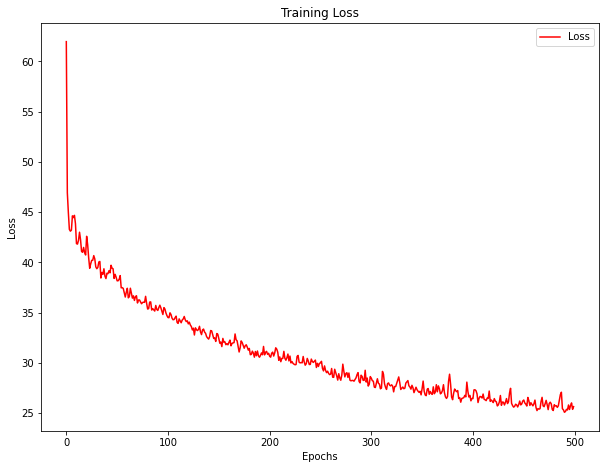

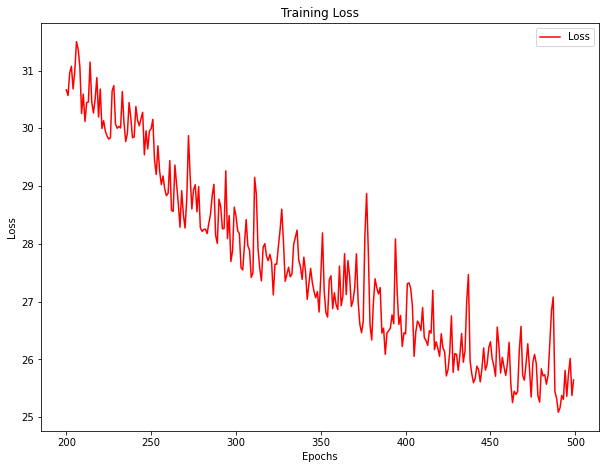

<Figure size 720x540 with 0 Axes>

In [10]:
import matplotlib.image as img

def loss_plotter(epochs, loss):
    plt.plot(epochs, loss, 'r')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Loss'])
    plt.figure()
    

loss = results.history['loss']
epochs = range(len(loss))
loss_plotter(epochs, loss)

zoomed_loss = loss[200:]
zoomed_epochs = range(200, 500)
loss_plotter(zoomed_epochs, zoomed_loss)